# Simulation of Contrained Properties
### Abstract
>Sometimes in the physical sciences it is necessary to build a simulation of a physical property. When a simulation is built the physical porperty value is calculated for various input values using a mathematical model of the property. The mathematical model having been obtained by fitting a function to experimental data. The most common functions used for modelling physical properties are often montonic and unconstrained (for example linear or polynomial regression). This means that the function can take every increasing or decreasing values at the extremes of input values. However, most physical properties have constraints on the values they can take, most physical properties have a defined zero value, few can take negative values. Exceptions to this are properties such as gain/attenuation measured in dB and pH measured in non-aqueous solution. Some properties may be measured relative to some datum and so may have a limited negative range, e.g. temperature in Celcius.
>
>When a simulation is run, since the underlying mathematical function are unconstrained, it is possible for the simulation to produce phyically invalid values, even when a value may be physically valid it may still be so extreme as to be a value that is never observed in nature, i.e. would domain invalid.
>
>Here a method for guaranteeing that simulated property values remain valid is investigated. If a simulation introduces noise (to produce a realistic (more natural) simulation), the effect of controling the character of the noise by summing after processing is compared to including oise before final processing.

## Introduction
Most physical properties are constrained to a range that is greater than zero (for absolute properties) or to fractional values in the range from 0 to 1, either inclusive or exclusive. Some properties are measured relative to a datum and so can take a limited range of negative values (e.g. temperature on the Fahrenheit or Celcius scale). Very few properties are physically unconstrained, examples include gain/attenuation measured in dB and pH in non-aqueous solutions (both of these properties are logarithms and can have negative values).

Often when fitting a model to experimental data simple functions are used (for example linear or polnomial regression) these functions have no inherent constraint on their range. So care must be taken when using these to build a simulation of the property. The simplest way to maintain a simulation that remains within the desired range is to clip the simulation (replace simulation values that are out of range to the nearest valid value). This however can introduce undesirable artefacts in the distribution of property values (excess at the limits of the valid range).

Compare this to using a neural network for classification, due to the use of a logistic activation function the output of a classifier is also within the range $(0, 1)$. Values in the range $(0,1)$ can be linear transformed into any arbitrary range. Let $y$ be a number in the range $(0,1)$ that is $y \in (0,1)$ then a property value $p$ in a range $\left(p_{min}, p_{max}\right)$ by $p = p_{min} + y\left(p_{max} - p_{min}\right)$. Thus if the last operation of building a simulation of a property is to apply a logistic transformation and scale and translate the result into the desired range it is guaranteed that the simulation values will be constrained to the desired range. This is the basis of soft-clipping.

All that is required is to find a function that will produce values that when the logistic function and the scaling and translation produces vaues that correctly estimate the property value we are simulating. This can be achieve by fitting the experimental data after the inverse to the logistic function has been applied. This inverse is the *logit* function.

### Soft Clipping
Soft clipping uses a mathematical transformation at the final step which always results in property values that will be valid. This can be achieved for any range of property values by starting with a transform which results in values greater than 0 and less than 1 and rescaling these into any range of values. This transform is based on a function which maps from the domain of real numbers to the range (0, 1), i.e. $ \mathbb{R} \mapsto (0, 1)$. *Note the domain of real number domain contains **all** real numbers, while the range (0, 1) contains only real numbers that are greater then 0 and less than 1.* It should be noted that the transform approaches the limits but never reaches them. Having found the transform for the final step it must be possible to transform the known data into a form that will retrieved by applying the final transform. (That is we need a transform which is reversible.) This inverse function maps the known values from a limited range (rescaled into the range (0,1) if necessary), into the domain of real numbers, for example $(x_{min}, x_{max}) \mapsto \mathbb{R}$

The steps to analyse experimental data, produce models that can then be used to build a simulation with all values within the correct range is as follows.

1. Transform experimental data from valid range to (0,1), $\left(p_{min}, p_{max}\right) \mapsto (0,1), p_{exp} \mapsto p_{exp}^\prime$.
1. Apply logit function $y_{exp} = \mathrm{logit}\left(p_{exp}^\prime\right): (0,1) \mapsto \mathbb{R}$
1. Perform analyis (e.g. linear regression) to produce a model function $\hat{y} = \mathrm{f}(\mathbf{x})$ where $\mathbf{x}$ are the independent variables from which $\hat{y}$ is estimated.
1. Build the simulation by calculating vales for $\hat{y}$ for various values of $\mathbf{x}: \mathbb{R}^n \mapsto \mathbb{R}$
1. Apply *logistic* function $\hat{p}^\prime = \mathrm{logisitic}\left(\hat{y}\right): \mathbb{R} \mapsto (0,1)$
1. Apply the sacling and translation required to return to desired range $\hat{p} = p_{min} + \hat{p}^\prime\left(p_{max} - p_{min}\right): (0,1) \mapsto \left(p_{min}, p_{max}\right)$

### Heteroscedasticity
For "realistic" simulation noise is added to the modelled values. It may be important to control the charater of the noise. Heteroscedasticity is the property that the uncertaintity (as measured by standard devaition) varys with one or more of the variables used to predict the property value. There may be situations where the heteroscedasticity needs to be modelled. 

A property of using the *logistic* transform as the last step in the soft clipping process is that the calculated values will be hetroscedastic (that is, the standard deviation will vary). This arises because the logistic function is non-linear so if the uncertainty in the logit property value is constant then when logistic transform is applied the uncertainty will smaller for small and large values (more negative and more positive logit values) and larger in the midlle (as the logit value pass through 0). The uncertainty in the property value will be proportional to the derivative of the logistic function. The logistic functions and its [derivative](https://en.wikipedia.org/wiki/Logistic_function#Derivative) are shown below.

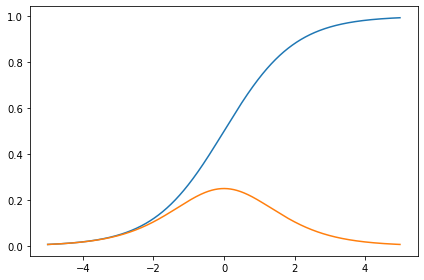

In [1]:
#matplotlib notebook
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import numpy as np
import statsmodels.api as sm
import math

from Transforms import logit, logistic, logistic_derivative
from SimulationPlots import run_simulation_noise_after, run_simulation_noise_before

# Vectorise logit and logistic functions
np_logistic = np.vectorize(logistic)
np_logit = np.vectorize(logit)
np_derivative = np.vectorize(logistic_derivative)

logit_values = np.arange(-5, 5, 0.01)
logistic_values = np_logistic(logit_values)
derivative_values = np_derivative(logit_values)

fig,ax = pyplot.subplots()
ax.plot(logit_values, logistic_values)
ax.plot(logit_values, derivative_values)
fig.tight_layout()

From these plots we see that a small perturbation for logit values close to 0 will result in large perturbations in the transformed value, while the same perturbation for logit value out in the wing (beyond $\pm4\sigma$) will result in small perturbation of the transformed value.

## Methodology
To investigate the use of soft clipping to modelling a constrained property a one dimensional (1D) system will be analysed using test data generated at random. The system can be thought of as a physical property that varys in the vertical dimension (e.g. depth, it will be plotted with the independent variable of the y-axis and the dependent variable of the x-axis as it might be in a real-world application). The randomly generated "experimental" data will have two clusters with different mean and variance.

The soft clipping approach will be applied by taking the logit transform of the "experimental" data, using linear regression to model the transformed data. Two cases will be investigated, one where the data (which is already in the range $(0,1)$ and the other where the soft clipping will constrain the result to the range $\left(0, 1.001p_{max}\right)$ where $p_{max}$ is the maximum value for the property in the "experimental" data set.

After the analysis of the experimental data is complete the effect of including noise in the simulation will be investigated by simulating the property and adding 100 simulations of the noise after and before the logistic transformation. The nature of the heteroscedasticty in these simulation is investigated using mean and standard deviation statatics for each point in the simulation (for each unique value of the independent variable) are calculated.

## Results
### 1. Generate Experimental Data

In [2]:
# Generate two clusters of random points
X1, label1 = make_blobs(n_samples=100, centers=1, n_features=2)
X2, label2 = make_blobs(n_samples=100, centers=1, n_features=2)

label1 = [1 for _ in label1]
label2 = [2 for _ in label2]

# Rescale to desired mean and std. dev.
mean1_x = X1[:,0].mean()
std_dev1_x = X1[:,0].std()
mean1_y = X1[:,1].mean()
std_dev1_y = X1[:,1].std()

average_property1 = 0.27
std_dev_property1 = 0.05
average_depth1 = -3250
std_dev_depth1 = 50
X1[:,0] = (X1[:,0] - mean1_x)*std_dev_depth1/std_dev1_x + average_depth1
X1[:,1] = (X1[:,1] - mean1_y)*std_dev_property1/std_dev1_y + average_property1


mean2_x = X2[:,0].mean()
std_dev2_x = X2[:,0].std()
mean2_y = X2[:,1].mean()
std_dev2_y = X2[:,1].std()

average_property2 = 0.12
std_dev_property2 = 0.02
average_depth2 = -4250
std_dev_depth2 = 50
X2[:,0] = (X2[:,0] - mean2_x)*std_dev_depth2/std_dev2_x + average_depth2
X2[:,1] = (X2[:,1] - mean2_y)*std_dev_property2/std_dev2_y + average_property2

mean1_x = X1[:,0].mean()
std_dev1_x = X1[:,0].std()
mean1_y = X1[:,1].mean()
std_dev1_y = X1[:,1].std()

mean2_x = X2[:,0].mean()
std_dev2_x = X2[:,0].std()
mean2_y = X2[:,1].mean()
std_dev2_y = X2[:,1].std()

DataFrame({'Mean Depth': [mean1_x, mean2_x], 'Depth Std. Dev.': [std_dev1_x, std_dev2_x],
           'Mean Property': [mean1_y, mean2_y], 'Property Std. Dev.': [std_dev1_y, std_dev2_y]}, 
          ['Top Cluster', 'Bottom Cluster'])

,Mean Depth,Depth Std. Dev.,Mean Property,Property Std. Dev.
Top Cluster,-3250.0,50.0,0.27,0.05
Bottom Cluster,-4250.0,50.0,0.12,0.02


To analyse this data, the property is scaled to limits between 0 and $1.001\phi_{T,max}$, the *logit* transform is applied to both scaled and unscaled data so the effect of scaling can be compared to leaving the possible range as $(0, 1)$. All this data is combined into a single `DataFrame` (a Python data table).

These clusters are as follows.

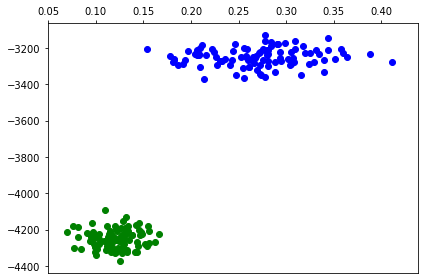

In [3]:
X = np.array(X1.tolist() + X2.tolist())
labels = np.array(label1 + label2)

max_property = X[:,1].max()*1.001


df = DataFrame(dict(depth=X[:,0], property=X[:,1], scaled_property=X[:,1]/max_property, 
                    logit_property=np_logit(X[:, 1]), logit_scaled_property=np_logit(X[:,1]/max_property), label=labels))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

grouped = df.groupby('label')
for key, group in grouped:
    ax.scatter(group.property, group.depth, label=key, color=colors[key])
fig.tight_layout()

The description of the data set is as follows.

In [4]:
df[['depth', 'property', 'scaled_property', 'logit_property', 'logit_scaled_property']].describe()

,depth,property,scaled_property,logit_property,logit_scaled_property
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-3750.000000,0.195000,0.473396,-1.508442,-0.079806
std,503.754746,0.084324,0.204711,0.550429,1.032074
min,-4372.347081,0.069813,0.169482,-2.589573,-1.589304
25%,-4249.903903,0.121279,0.294425,-1.980377,-0.873991
50%,-3733.691228,0.164254,0.398755,-1.627020,-0.410719
75%,-3248.471167,0.272603,0.661790,-0.981457,0.671281
max,-3126.755727,0.411506,0.999001,-0.357744,6.907755


### 2. Data Analysis
The data analysis step uses linear regression to find the property trend.

In [5]:
depth = df.depth
logit_property = df.logit_property
logit_scaled = df.logit_scaled_property

depth = sm.add_constant(depth)

linear_model = sm.OLS(logit_property, depth).fit()
linear_model_scaled = sm.OLS(logit_scaled, depth).fit()
DataFrame([linear_model.params, linear_model_scaled.params], ['Property', 'Scaled Property'])

,const,depth
Property,2.201461,0.000989
Scaled Property,6.033034,0.001630


This trend can be visualised, and the $\pm\sigma$ and $\pm4\sigma$ limits can be included.

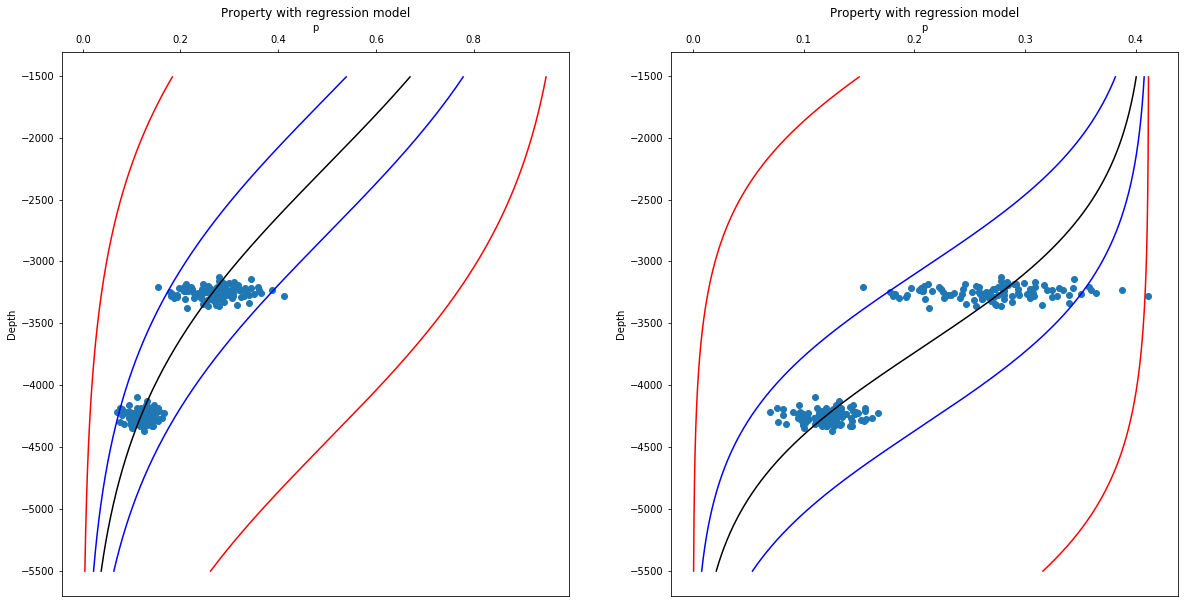

In [6]:
logit_std_dev = logit_property.std()
logit_4_std_dev = 4 * logit_std_dev

logit_scaled_std_dev = logit_scaled.std()
logit_scaled_4_std_dev = 4 * logit_scaled_std_dev
depths = np.arange(-5500, -1500, 10)
fig, [ax, ax2] = pyplot.subplots(1,2, figsize=(20,10))
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_title("Property with regression model")
ax.set_xlabel("p")
ax.set_ylabel("Depth")
ax.scatter(df.property, df.depth)
trend = [linear_model.params.depth * z + linear_model.params.const for z in depths]
trend_plus_1_std_dev = [t + logit_std_dev for t in trend]
trend_plus_4_std_dev = [t + logit_4_std_dev for t in trend]
trend_minus_1_std_dev = [t - logit_std_dev for t in trend]
trend_minus_4_std_dev = [t - logit_4_std_dev for t in trend]
ax.plot(np_logistic(trend), depths, 'k');
ax.plot(np_logistic(trend_plus_1_std_dev), depths, 'b');
ax.plot(np_logistic(trend_minus_1_std_dev), depths, 'b');
ax.plot(np_logistic(trend_plus_4_std_dev), depths, 'r');
ax.plot(np_logistic(trend_minus_4_std_dev), depths, 'r');

ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 
ax2.set_title("Property with regression model")
ax2.set_xlabel("p")
ax2.set_ylabel("Depth")
ax2.scatter(df.property, df.depth)
trend = [linear_model_scaled.params.depth * z + linear_model_scaled.params.const for z in depths]
trend_plus_1_std_dev = [t + logit_scaled_std_dev for t in trend]
trend_plus_4_std_dev = [t + logit_scaled_4_std_dev for t in trend]
trend_minus_1_std_dev = [t - logit_scaled_std_dev for t in trend]
trend_minus_4_std_dev = [t - logit_scaled_4_std_dev for t in trend]
ax2.plot(np_logistic(trend)*max_property, depths, 'k');
ax2.plot(np_logistic(trend_plus_1_std_dev)*max_property, depths, 'b');
ax2.plot(np_logistic(trend_minus_1_std_dev)*max_property, depths, 'b');
ax2.plot(np_logistic(trend_plus_4_std_dev)*max_property, depths, 'r');
ax2.plot(np_logistic(trend_minus_4_std_dev)*max_property, depths, 'r');

### 3. Simulation
As explained in the introduction to heteroscedasticity, the logisitic function introduces its own heteroscedastic effect. So if there is a model of heteroscedasticity (e.g. the standard deviation varies linearly with depth, as we will model later), then including this model in the logit space will result in a simulated model that does **not** honour this. So the effect of adding simulations of the noise according to a specific model of heteroscedasticity after the noise free model has been produced is investigated.

#### Case 1: Apply Heteroscedastic Model after Logistic Transform
To study the effect of various types of noise, the case where the standard deviation vary both linearly and logistically with depth, as well as a model where the standard deviation is constant with depth as investigated. The method of investigation is to generate 100 simulations of each model and combine them with noise-free model. At each depth the mean and standard deviation are calculated. This data is visualised showing the simulations plus the mean and $\pm\sigma$ and $\pm4\sigma$ limits.

For clarity the simulation code has been moved to a file and imported. The data points highlighted in orange are those that are outside the valid range.

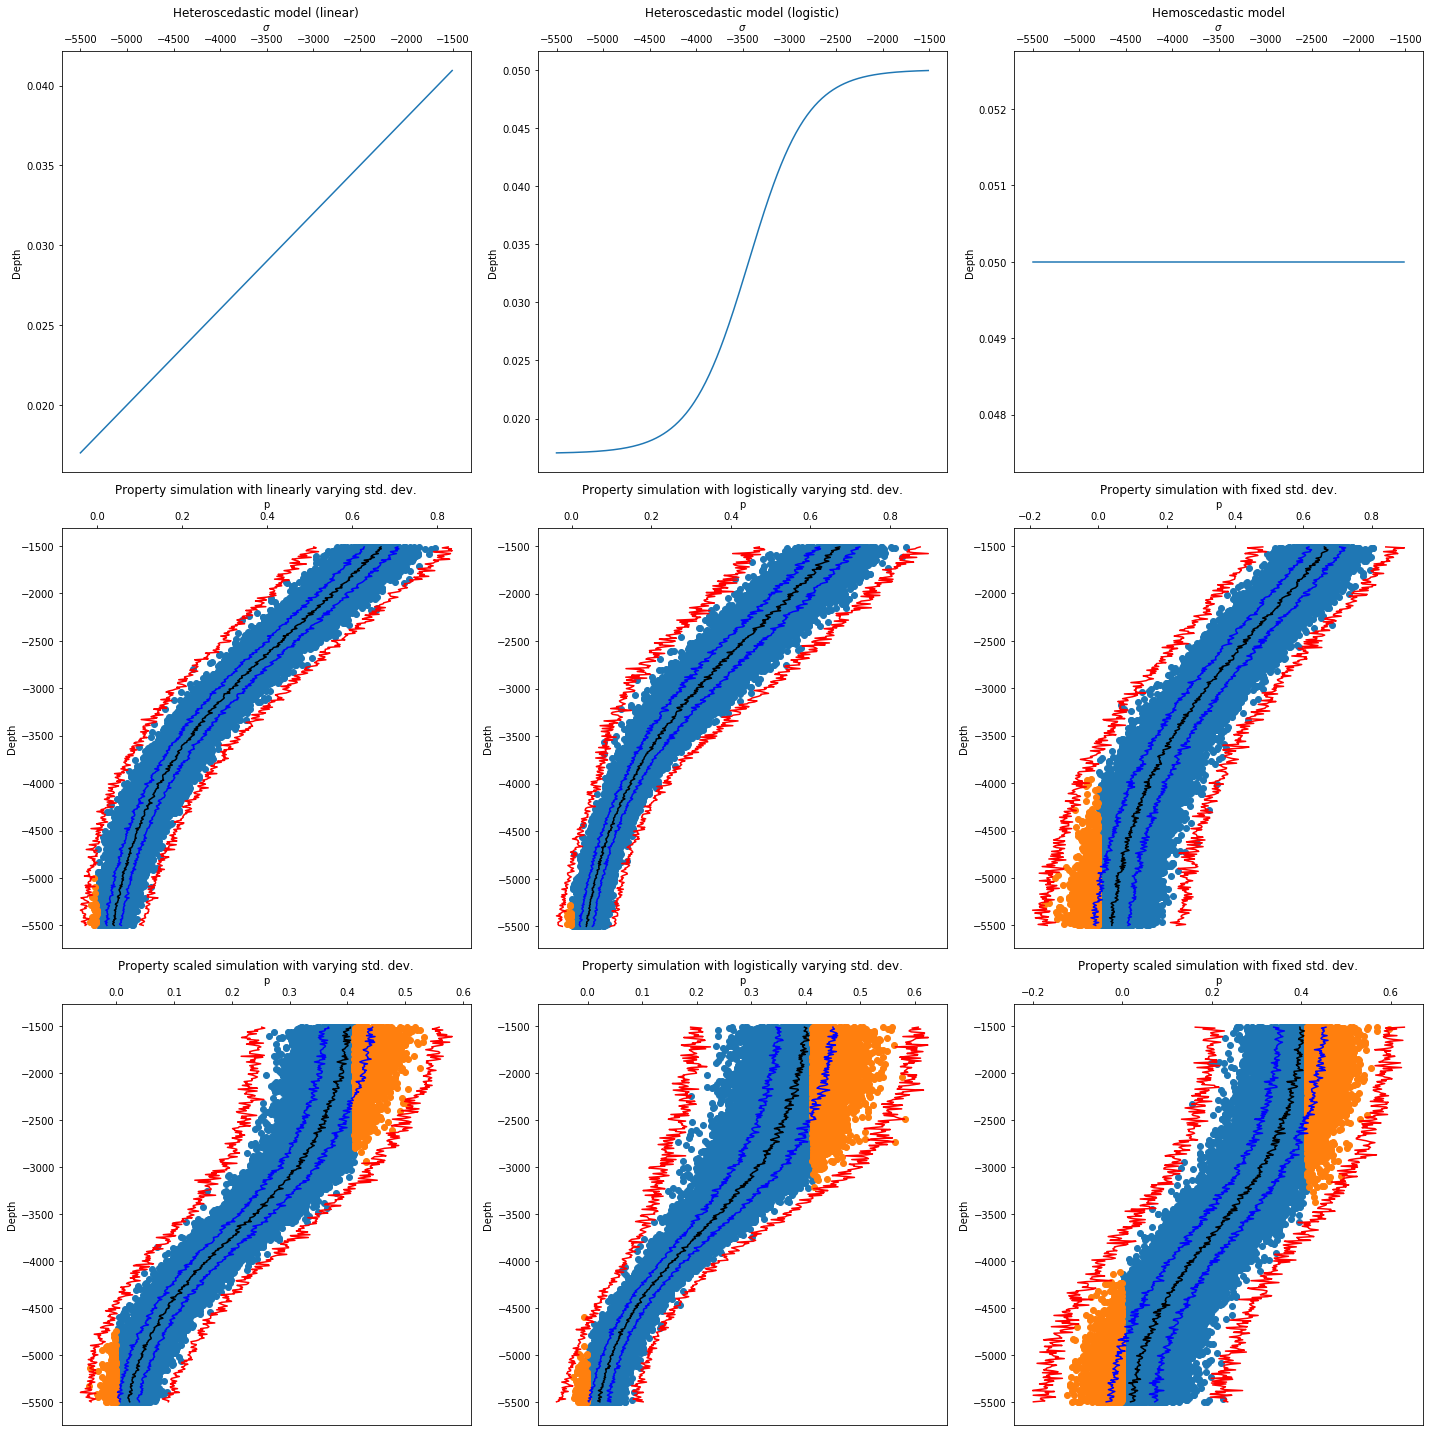

In [7]:
std_dev_surface = 0.05
std_dev_slope = 6e-6

logistic_std_dev_surface = 11.0
logistic_std_dev_slope = 0.0032
logisitic_std_dev_min = 0.017
logistic_std_dev_range = 0.033

depths = np.arange(-5500, -1500, 10).tolist()
cell_count, \
    unscaled_hetero_invalid_count, \
    unscaled_logistic_invalid_count, \
    unscaled_homo_invalid_count, \
    scaled_hetero_invalid_count, \
    scaled_logistic_invalid_count, \
    scaled_homo_invalid_count = run_simulation_noise_after(depths, linear_model, linear_model_scaled, max_property,
        std_dev_surface, std_dev_slope,
        logistic_std_dev_surface, logistic_std_dev_slope, logistic_std_dev_range, logisitic_std_dev_min)

The following is a summary of the invalid values.

In [8]:
DataFrame({'Count': [unscaled_hetero_invalid_count,
                     unscaled_logistic_invalid_count,
                     unscaled_homo_invalid_count, 
                     scaled_hetero_invalid_count,
                     scaled_logistic_invalid_count,
                     scaled_homo_invalid_count],
           'Percentage': [unscaled_hetero_invalid_count/cell_count*100,
                          unscaled_logistic_invalid_count/cell_count*100,
                          unscaled_homo_invalid_count/cell_count*100, 
                          scaled_hetero_invalid_count/cell_count*100,
                          scaled_logistic_invalid_count/cell_count*100,
                          scaled_homo_invalid_count/cell_count*100]},
         ['Heteroscedastic Unscaled (linear)', 'Heteroscedastic Unscaled (logistic)', 'Homescedastic Unscaled', 
          'Heteroscedastic Scaled (linear)', 'Heteroscedastic Scaled (logistic)', 'Homescedastic Scaled'])

,Count,Percentage
Heteroscedastic Unscaled (linear),30,0.0750
Heteroscedastic Unscaled (logistic),23,0.0575
Homescedastic Unscaled,1227,3.0675
Heteroscedastic Scaled (linear),2872,7.1800
Heteroscedastic Scaled (logistic),3557,8.8925
Homescedastic Scaled,5509,13.7725


#### Case 2: Apply Heteroscedastic Model before Logistic Transform
In this case the trend is calculated in logit space then 100 noise simulations are added. After some trial and error two models were chosen, one is a constant $\sigma = 0.35$ and the other is $\sigma = 0.123 - 2.25 \times 10^{-6}$. As before the results are concatenated and plotted. In addition to the scatter plot the data is grouped by depth and the mean and standard deviation is calculate for each depth. The mean value and $\pm1\sigma$ and $\pm4\sigma$ lines are also displayed.

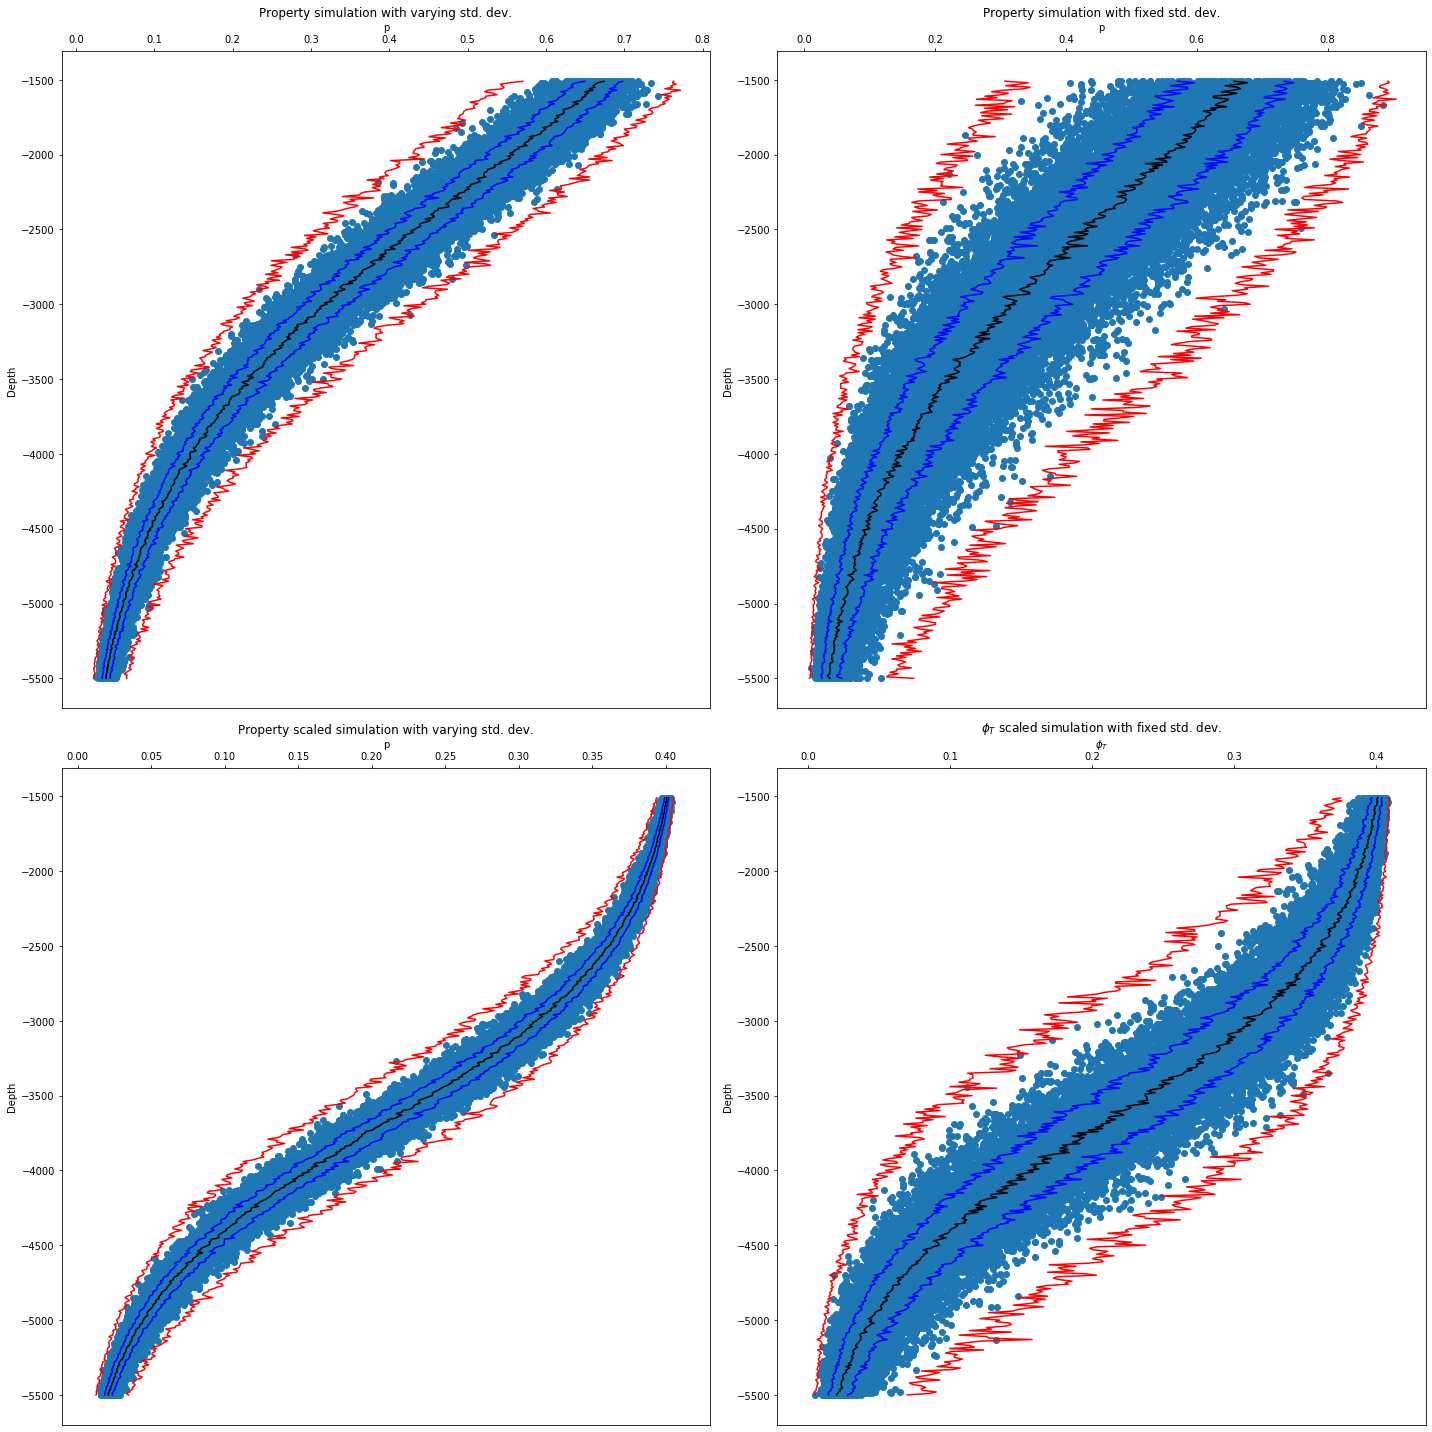

In [13]:
logit_std_dev_slope = -2.24e-06
logit_std_dev_surface = 0.123

depths = np.arange(-5500, -1500, 10).tolist()
run_simulation_noise_before(depths, linear_model, linear_model_scaled, max_property,
                            logit_std_dev_surface, logit_std_dev_slope)

## Discussion
Soft clipping provides a means to simulate physical properties which have a constrained range of values, either physically valid or the observed range of values is known to be limits. Often for realistic simulations noise is added, often this noise has heteroscedasticity, if a particular model of this heteroscedasticity is required then it should be applied after the noise-free  simulated value of the property have been calculated. However, if care is not taken in fitting the underlying trend function the noise can produce values which are not valid. It may be possible to constrain the fitting algorithm to ensure that the noise-free value if at least $4\sigma$ or $5\sigma$ from the constraint limits. (This is likely to be very difficult to do.)